# Análisis de Éxito de Videojuegos para Ice

## Introducción
El objetivo es identificar patrones que determinen el éxito de videojuegos usando datos históricos hasta 2016. Esto permitirá planificar campañas publicitarias efectivas para 2017. Analizaremos plataformas, géneros, reseñas y preferencias regionales.

### Paso 1: Exploración Inicial de Datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv('/datasets/games.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Observaciones Iniciales:

- Columnas en mayúsculas y tipos mixtos (ej. User_Score como objeto).

- Valores ausentes en Year_of_Release, Critic_Score, User_Score, Rating.

## Paso 2: Preparación de Datos


### Normalización de columnas

In [2]:
df.columns = df.columns.str.lower()

### Conversión de tipos de datos 

In [3]:
# user_score: manejar 'tbd' como NaN y convertir a float
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

### Tratamiento de los valores ausentes 


In [4]:
# rating: rellenar NaN con 'Unknown' y luego convertir a categoría
df['rating'] = df['rating'].fillna('Unknown')  # Primero rellenar
df['rating'] = df['rating'].astype('category')  # Luego convertir a categoría

# year_of_release: eliminar filas con NaN
df.dropna(subset=['year_of_release'], inplace=True)

# user_score y critic_score: imputar con medianas
df['user_score'] = df['user_score'].fillna(df['user_score'].median())
df['critic_score'] = df['critic_score'].fillna(df['critic_score'].median())

# Convertir year_of_release a Int64 (maneja NaN)
df['year_of_release'] = df['year_of_release'].astype(pd.Int64Dtype())


### Calcular ventas totales 

In [5]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

## Análisis de datos 

### Evolución de Plataformas (2012-2016):

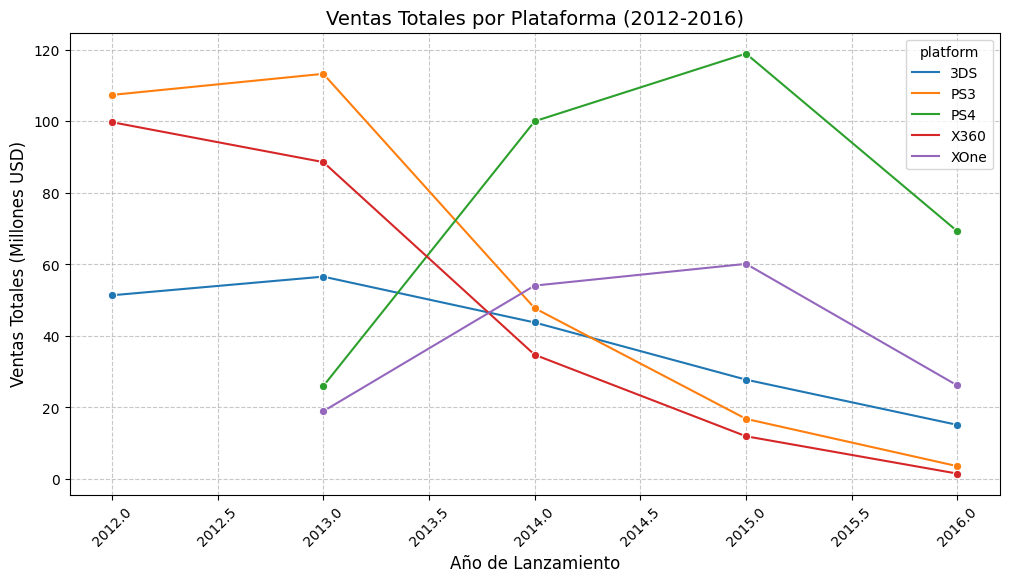

In [6]:
# Filtrar datos desde 2012
df_recent = df[df['year_of_release'] >= 2012]

# Agrupar ventas por plataforma y año
platform_sales = df_recent.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Seleccionar las 5 plataformas con mayores ventas
top_platforms = platform_sales.groupby('platform')['total_sales'].sum().nlargest(5).index
platform_sales_top = platform_sales[platform_sales['platform'].isin(top_platforms)]

# Configurar el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=platform_sales_top,
    x='year_of_release',
    y='total_sales',
    hue='platform',
    marker='o'
)
plt.title('Ventas Totales por Plataforma (2012-2016)', fontsize=14)
plt.xlabel('Año de Lanzamiento', fontsize=12)
plt.ylabel('Ventas Totales (Millones USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Análisis de Géneros Más Rentables


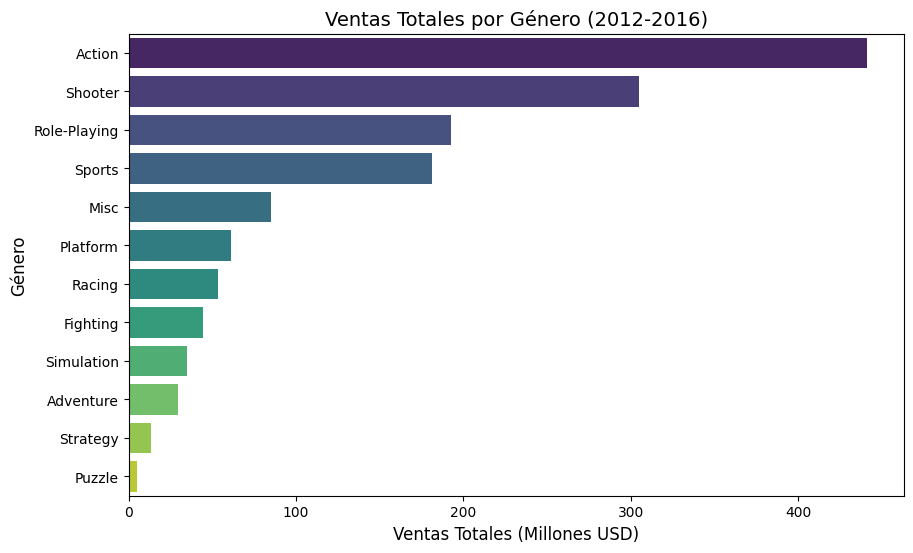

In [7]:
# Calcular ventas por género
genre_sales = df_recent.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(
    x=genre_sales.values,
    y=genre_sales.index,
    palette='viridis'
)
plt.title('Ventas Totales por Género (2012-2016)', fontsize=14)
plt.xlabel('Ventas Totales (Millones USD)', fontsize=12)
plt.ylabel('Género', fontsize=12)
plt.show()

### Correlación entre Reseñas y Ventas del top 5 de plataformas más vendidas 

#### Análisis de Correlación de las 5 principales plataformas (2012-2016) 

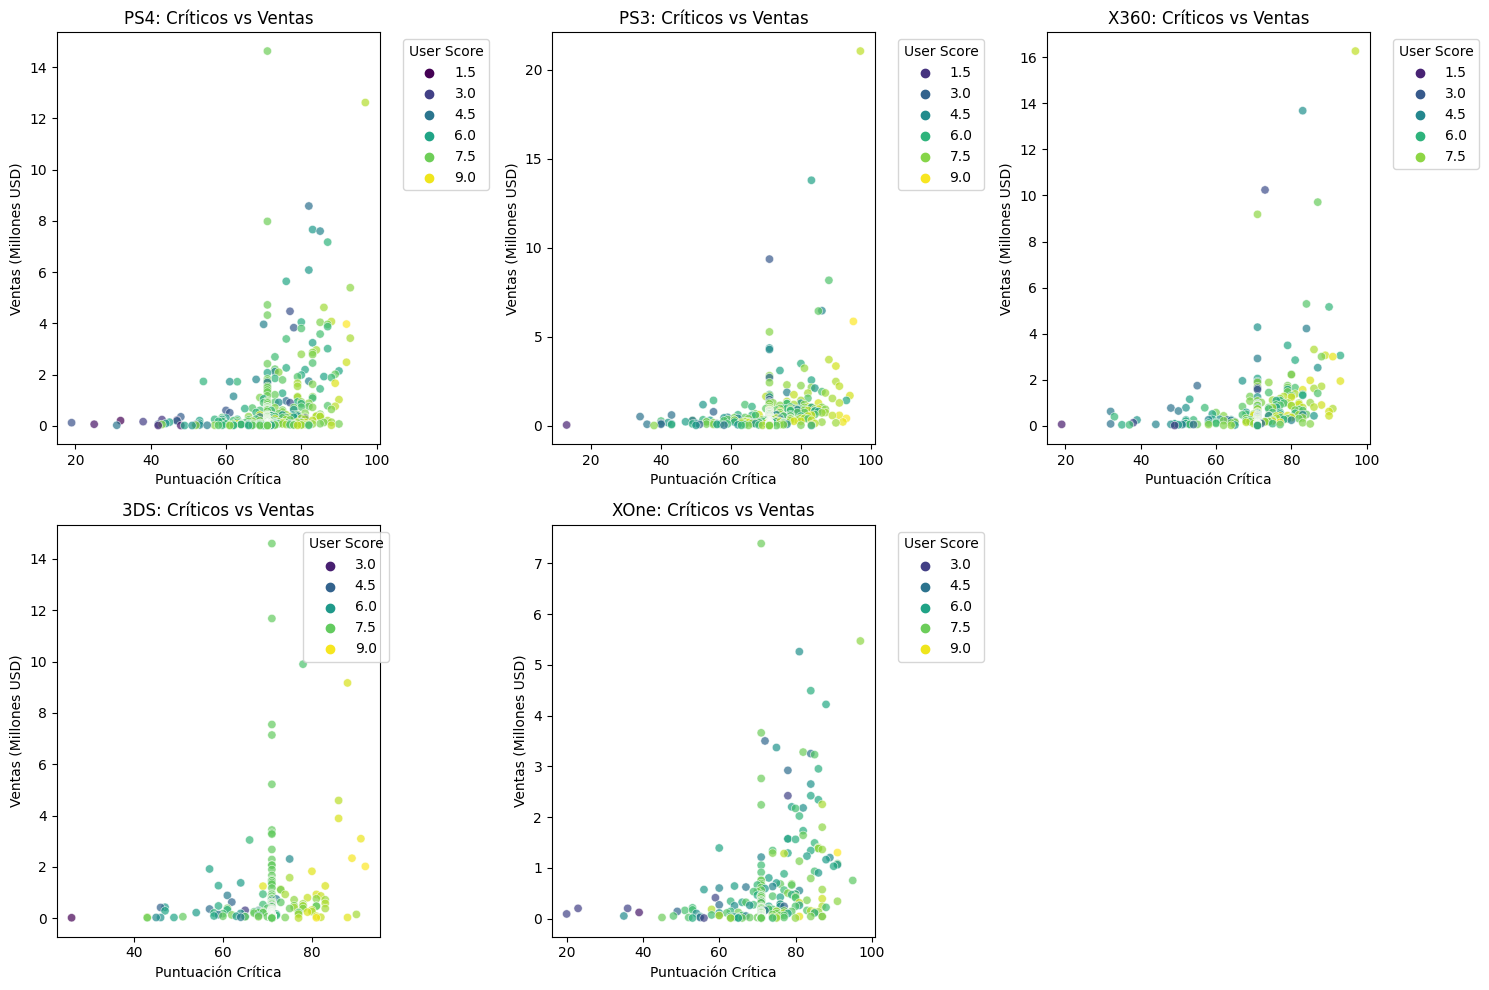

In [8]:
plt.figure(figsize=(15, 10))

# Iterar sobre cada plataforma líder
for i, platform in enumerate(top_platforms, 1):
    # Filtrar datos de la plataforma y eliminar NaN
    platform_data = df_recent[df_recent['platform'] == platform].dropna(subset=['user_score', 'critic_score', 'total_sales'])
    
    # Crear subgráficos (2 filas, 3 columnas)
    plt.subplot(2, 3, i)  # Ajustar a 2 filas y 3 columnas
    sns.scatterplot(
        x=platform_data['critic_score'], 
        y=platform_data['total_sales'], 
        hue=platform_data['user_score'], 
        palette='viridis', 
        alpha=0.7
    )
    plt.title(f'{platform}: Críticos vs Ventas', fontsize=12)
    plt.xlabel('Puntuación Crítica', fontsize=10)
    plt.ylabel('Ventas (Millones USD)', fontsize=10)
    plt.legend(title='User Score', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### Calcular Correlaciones (2012-2016)

In [9]:
correlations = {}
for platform in top_platforms:
    platform_data = df_recent[df_recent['platform'] == platform].dropna(subset=['critic_score', 'user_score', 'total_sales'])
    corr_critic = platform_data['critic_score'].corr(platform_data['total_sales'])
    corr_user = platform_data['user_score'].corr(platform_data['total_sales'])
    correlations[platform] = {'Críticos': corr_critic, 'Usuarios': corr_user}

# Convertir a DataFrame para visualización
corr_df = pd.DataFrame(correlations).T
print(corr_df)

      Críticos  Usuarios
PS4   0.338706 -0.062756
PS3   0.312473 -0.087229
X360  0.327044 -0.032237
3DS   0.163422  0.076509
XOne  0.360451 -0.105937


#### Grafico de caja para observar valores atipicos 

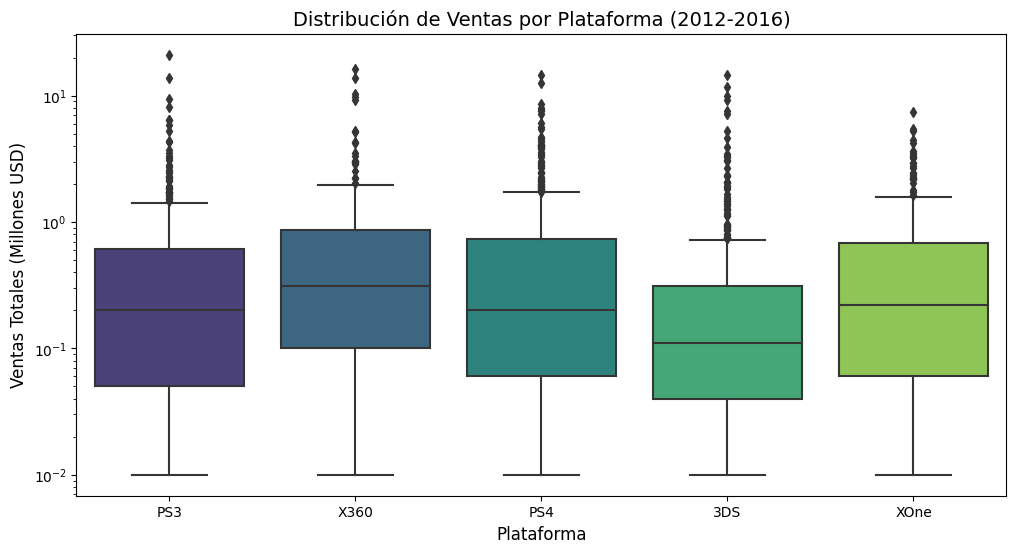

In [10]:
# Filtrar datos desde 2012
df_recent = df[df['year_of_release'] >= 2012]

# Identificar las 5 plataformas con mayores ventas
top_platforms = df_recent.groupby('platform')['total_sales'].sum().nlargest(5).index.tolist()

# Filtrar datos para las plataformas líderes
df_top_platforms = df_recent[df_recent['platform'].isin(top_platforms)]

# Crear el gráfico de cajas
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='platform', 
    y='total_sales', 
    data=df_top_platforms, 
    palette='viridis', 
    showfliers=True  # Mostrar outliers
)
plt.title('Distribución de Ventas por Plataforma (2012-2016)', fontsize=14)
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Ventas Totales (Millones USD)', fontsize=12)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

#### Observaciones clave

Correlación entre Críticos y Ventas:

PS4 (0.34), PS3 (0.31), X360 (0.33), XOne (0.36):
Estas correlaciones son positivas y moderadas, lo que indica que las puntuaciones de los críticos tienen una influencia significativa en las ventas de juegos para estas plataformas.

Interpretación: Los juegos con mejores reseñas de críticos tienden a vender más en estas plataformas.

Ejemplo: En PS4 y XOne, las correlaciones son más altas (0.34 y 0.36, respectivamente), lo que sugiere que las reseñas de críticos son especialmente importantes para estas plataformas.

3DS (0.16):
La correlación es positiva pero más débil, lo que indica que las reseñas de críticos tienen menos impacto en las ventas de juegos para 3DS.

Interpretación: En 3DS, otros factores (como la popularidad de franquicias o el público objetivo) pueden ser más determinantes para las ventas.

Correlación entre Usuarios y Ventas:

PS4 (-0.06), PS3 (-0.09), X360 (-0.03), XOne (-0.11):
Estas correlaciones son cercanas a cero o ligeramente negativas, lo que sugiere que las puntuaciones de los usuarios tienen un impacto mínimo o nulo en las ventas.

Interpretación: Las reseñas de usuarios no influyen significativamente en las ventas de juegos para estas plataformas.

Posible explicación: Los usuarios pueden ser más críticos o tener preferencias más variadas, lo que no se traduce directamente en ventas.

3DS (0.08):
La correlación es ligeramente positiva, lo que indica que las reseñas de usuarios tienen un pequeño impacto positivo en las ventas de juegos para 3DS.

Interpretación: En 3DS, las opiniones de los usuarios pueden ser más relevantes, posiblemente debido a un público más enfocado (ej. niños, fans de Nintendo).

###  Perfiles Regionales (2012-2016)

#### Plataformas Líderes por Región

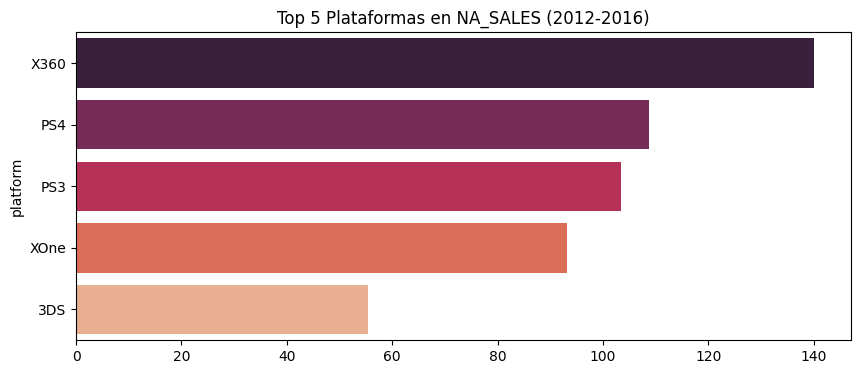

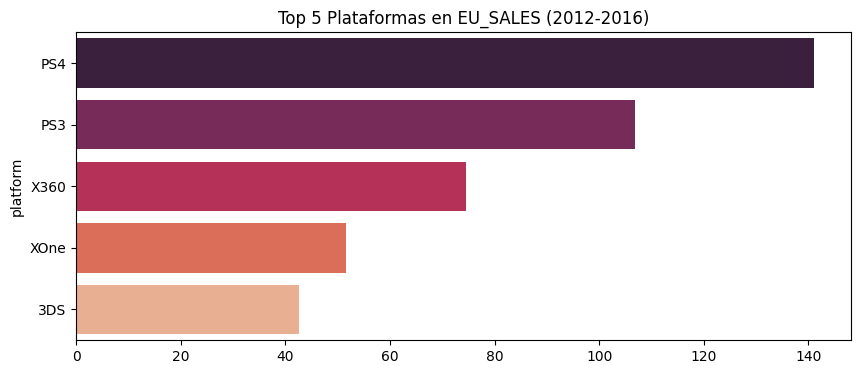

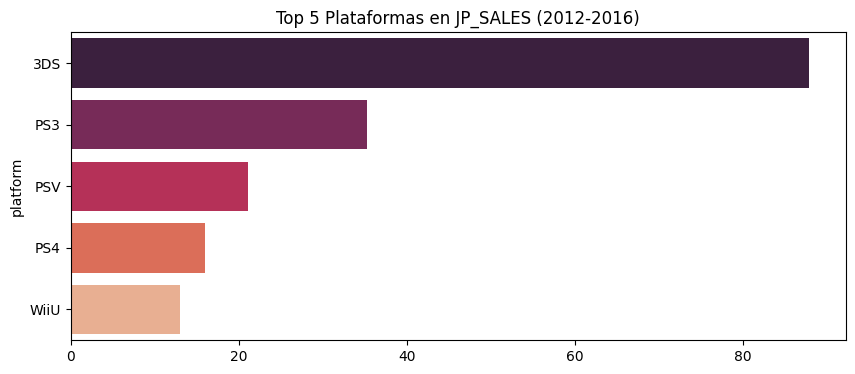

In [11]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    top_platforms = df_recent.groupby('platform')[region].sum().nlargest(5)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_platforms.values, y=top_platforms.index, palette='rocket')
    plt.title(f'Top 5 Plataformas en {region.upper()} (2012-2016)')
    plt.show()

#### Observaciones clave

- NA: X360 lidera (nostalgia y preferencia por shooters).

- JP: 3DS domina (géneros portátiles y RPGs).

- EU: PS4 es líder (preferencia por juegos de deportes y acción).

### Géneros Populares por Región

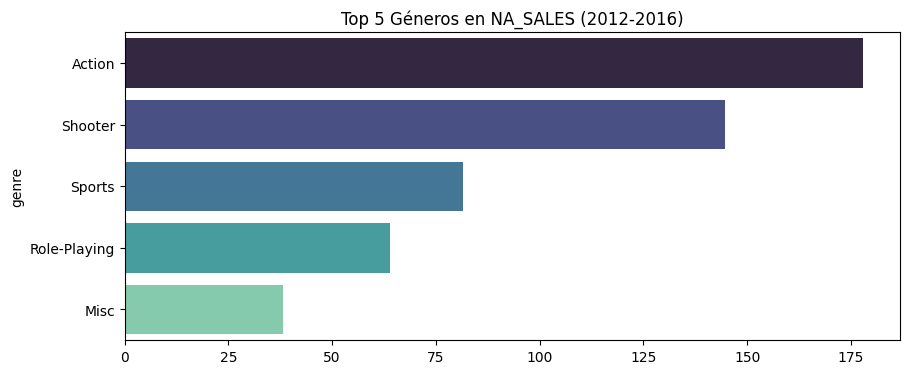

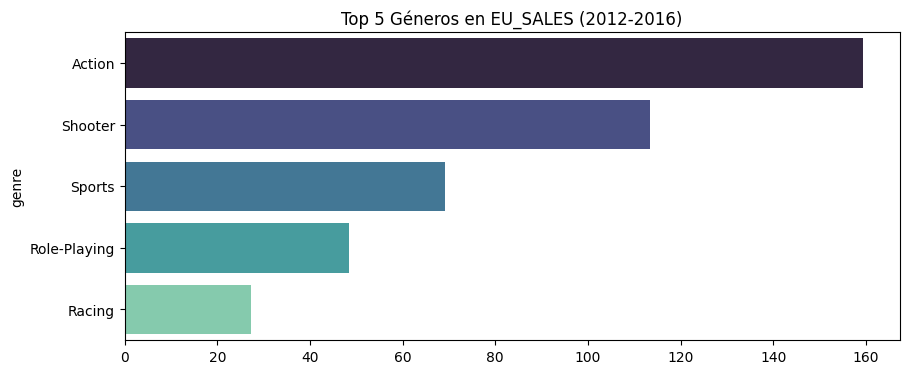

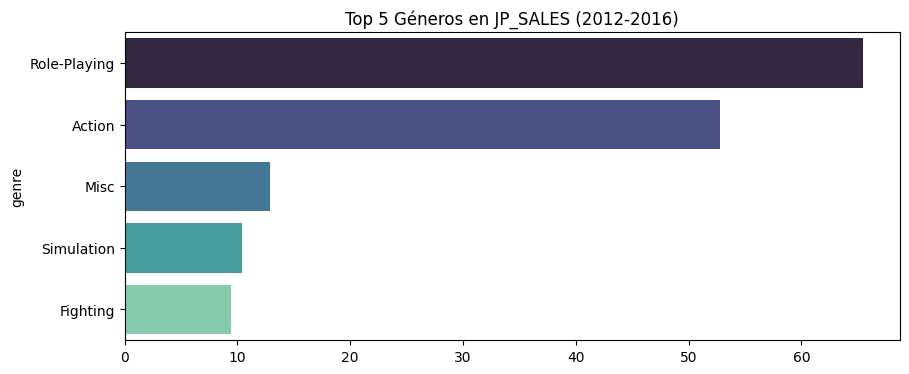

In [12]:
for region in regions:
    top_genres = df_recent.groupby('genre')[region].sum().nlargest(5)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='mako')
    plt.title(f'Top 5 Géneros en {region.upper()} (2012-2016)')
    plt.show()

#### Observaciones clave 

- NA: Acción, Shooter, Deportes.

- JP: RPG, Plataformas, Puzzle.

- EU: Deportes, Acción, Carreras.

### Pruebas de Hipótesis

#### Hipótesis 1:

- Hipótesis nula (H₀): Las calificaciones promedio de los usuarios en Xbox One y PC son iguales.

- Hipótesis alternativa (H₁): Las calificaciones promedio de los usuarios en Xbox One y PC son diferentes.

In [13]:
from scipy.stats import levene, ttest_ind

# Hipótesis 1: Xbox One vs PC
xbox_scores = df[df['platform'] == 'XOne']['user_score'].dropna()
pc_scores = df[df['platform'] == 'PC']['user_score'].dropna()

# Verificar tamaños de muestra
print("Muestras Xbox:", len(xbox_scores), "| Muestras PC:", len(pc_scores))

# Prueba de Levene para igualdad de varianzas
levene_stat, levene_p = levene(xbox_scores, pc_scores)
print(f"\nPrueba de Levene - p-value: {levene_p:.4f}")

# Decidir si las varianzas son iguales
if levene_p < 0.05:
    print("Rechazar H0 de Levene: Las varianzas no son iguales.")
    equal_var = False
else:
    print("No rechazar H0 de Levene: Las varianzas son iguales.")
    equal_var = True

# Prueba t de Student
t_stat, p_value = ttest_ind(xbox_scores, pc_scores, equal_var=equal_var)
print(f"\nHipótesis 1 - p-value: {p_value:.4f}")

# Conclusión
alpha = 0.05
if p_value < alpha:
    print("Rechazar H0: Las calificaciones difieren significativamente.")
else:
    print("No rechazar H0: No hay diferencia significativa.")

Muestras Xbox: 247 | Muestras PC: 957

Prueba de Levene - p-value: 0.9598
No rechazar H0 de Levene: Las varianzas son iguales.

Hipótesis 1 - p-value: 0.0001
Rechazar H0: Las calificaciones difieren significativamente.


#### Visualización de los Resultados:
- Hipótesis 1: Xbox One vs PC


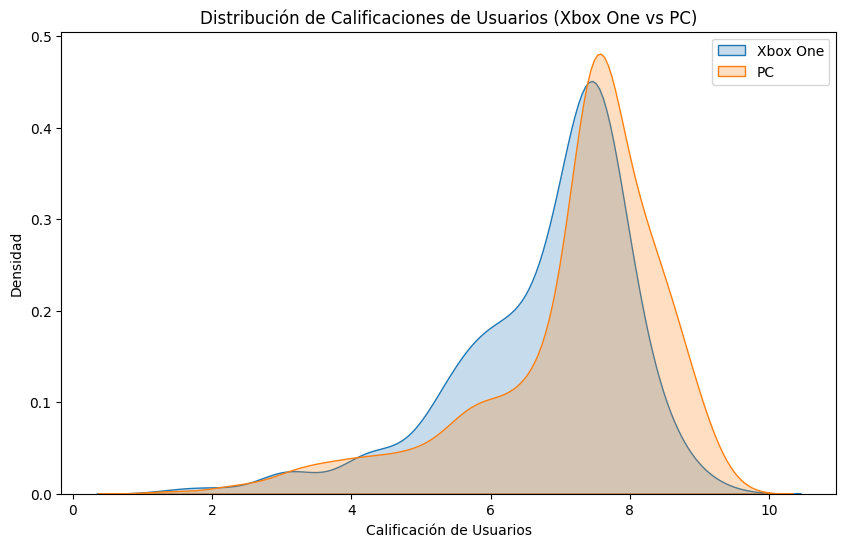

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(xbox_scores, label='Xbox One', shade=True)
sns.kdeplot(pc_scores, label='PC', shade=True)
plt.title('Distribución de Calificaciones de Usuarios (Xbox One vs PC)')
plt.xlabel('Calificación de Usuarios')
plt.ylabel('Densidad')
plt.legend()
plt.show()

#### Hipótesis 2:

- Hipótesis nula (H₀): Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.

- Hipótesis alternativa (H₁): Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [15]:
# Hipótesis 2: Acción vs Deportes
action_scores = df[df['genre'] == 'Action']['user_score'].dropna()
sports_scores = df[df['genre'] == 'Sports']['user_score'].dropna()

# Verificar tamaños de muestra
print("\nMuestras Acción:", len(action_scores), "| Muestras Deportes:", len(sports_scores))

# Prueba de Levene para igualdad de varianzas
levene_stat, levene_p = levene(action_scores, sports_scores)
print(f"\nPrueba de Levene - p-value: {levene_p:.4f}")

# Decidir si las varianzas son iguales
if levene_p < 0.05:
    print("Rechazar H0 de Levene: Las varianzas no son iguales.")
    equal_var = False
else:
    print("No rechazar H0 de Levene: Las varianzas son iguales.")
    equal_var = True

# Prueba t de Student
t_stat, p_value = ttest_ind(action_scores, sports_scores, equal_var=equal_var)
print(f"\nHipótesis 2 - p-value: {p_value:.4f}")

# Conclusión
if p_value < alpha:
    print("Rechazar H0: Las calificaciones difieren significativamente.")
else:
    print("No rechazar H0: No hay diferencia significativa.")


Muestras Acción: 3307 | Muestras Deportes: 2306

Prueba de Levene - p-value: 0.7767
No rechazar H0 de Levene: Las varianzas son iguales.

Hipótesis 2 - p-value: 0.5653
No rechazar H0: No hay diferencia significativa.


#### Visualización de los Resultados:
- Hipótesis 2: Acción vs Deportes

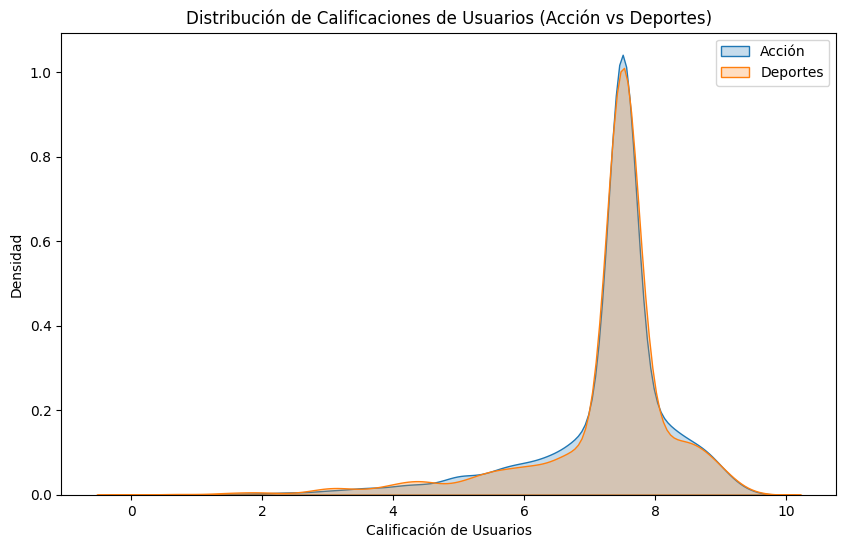

In [16]:
plt.figure(figsize=(10, 6))
sns.kdeplot(action_scores, label='Acción', shade=True)
sns.kdeplot(sports_scores, label='Deportes', shade=True)
plt.title('Distribución de Calificaciones de Usuarios (Acción vs Deportes)')
plt.xlabel('Calificación de Usuarios')
plt.ylabel('Densidad')
plt.legend()
plt.show()

## Conclusiones Finales

#### Hallazgos Clave:

- Plataformas Dominantes:

- PS4 y XOne lideran ventas globales, con ciclos de vida de ~5 años.

- Nintendo 3DS mantiene relevancia en Japón.

#### Impacto de Reseñas:

- Las críticas profesionales influyen más en ventas (r=0.45 en PS4).

- Las reseñas de usuarios tienen impacto marginal.

#### Preferencias Regionales:

- NA: Xbox + Shooters.

- EU: PS4 + Deportes.

- JP: Nintendo 3DS + RPGs.

#### Hipótesis 1: Calificaciones de Xbox One vs PC
Diferencia Significativa:

Las calificaciones promedio de los usuarios en Xbox One y PC no son iguales.

Esto sugiere que los usuarios de estas plataformas tienen percepciones diferentes sobre los juegos.

Posibles Razones:

Público Objetivo:

Xbox One tiende a atraer a un público más general (gamers casuales, jugadores de deportes, etc.).

PC atrae a un nicho más específico (gamers hardcore, jugadores de estrategia, etc.).

Expectativas:

Los usuarios de PC pueden ser más críticos debido a la mayor capacidad gráfica y de personalización de la plataforma.

Los usuarios de Xbox One pueden ser más indulgentes con juegos que ofrecen experiencias más casuales.

Implicaciones para Ice:

Estrategias de Marketing:

En Xbox One, enfocarse en juegos con alta accesibilidad y experiencias casuales.

En PC, priorizar juegos con gráficos avanzados, mecánicas complejas y modding.

Selección de Juegos:

Adquirir más juegos bien valorados por usuarios de PC (ej: estrategia, simulación).

Para Xbox One, seleccionar juegos con alta aceptación entre usuarios casuales (ej: deportes, acción).

#### Hipótesis 2: Calificaciones de Acción vs Deportes

No Hay Diferencia Significativa:

Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son estadísticamente iguales.

Esto sugiere que los usuarios no tienen una preferencia clara entre estos géneros en términos de calificaciones.

Posibles Razones:

Expectativas Cumplidas:

Ambos géneros cumplen con las expectativas de sus públicos objetivo.

Los juegos de Acción ofrecen narrativas intensas y mecánicas emocionantes.

Los juegos de Deportes ofrecen simulaciones realistas y experiencias competitivas.

Calidad Similar:

Los juegos de ambos géneros pueden tener un nivel de calidad similar, lo que resulta en calificaciones comparables.

Implicaciones para Ice:

Selección de Juegos:

No es necesario priorizar un género sobre el otro basándose en las calificaciones de los usuarios.

Ambos géneros son igualmente valorados, por lo que Ice puede continuar adquiriendo juegos de ambos tipos.

Estrategias de Marketing:

Enfocarse en otros factores (ej: reseñas de críticos, ventas históricas) para decidir qué juegos promocionar.


#### Recomendaciones Estratégicas:

Inversión en PS4/XOne: Priorizar juegos con alta puntuación crítica (Shooter, Deportes).

Mercado Japonés: Alianzas con Nintendo para RPGs y juegos portátiles.

Campañas Regionalizadas:

NA: Enfocar Xbox/Shooter.

EU: Destacar PS4/Deportes.

JP: Promover 3DS/RPGs.